In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import geopandas as gpd
import folium

# Load dataset
file_path = 'Electric_Vehicle_Population_Data.csv'
df = pd.read_csv(file_path)

# Display dataset info
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210165 entries, 0 to 210164
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         210165 non-null  object 
 1   County                                             210161 non-null  object 
 2   City                                               210161 non-null  object 
 3   State                                              210165 non-null  object 
 4   Postal Code                                        210161 non-null  float64
 5   Model Year                                         210165 non-null  int64  
 6   Make                                               210165 non-null  object 
 7   Model                                              210165 non-null  object 
 8   Electric Vehicle Type                              210165 non-null  object

In [52]:
# Drop columns with excessive missing or zero values (like MSRP)
df_cleaned = df.copy()


# Encode categorical variables
label_encoders = {}
for col in ['Electric Vehicle Type', 'Make','Model', 'County', 'City', 'Legislative District']:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col].astype(str))
    label_encoders[col] = le

# Drop rows with remaining NaN values
df_cleaned.dropna(inplace=True)

# Standardize numerical features for clustering and modeling
scaler = StandardScaler()
df_cleaned[['Electric Range', 'Model Year']] = scaler.fit_transform(df_cleaned[['Electric Range', 'Model Year']])


# Logistic Regression for CAFV Eligibility

In [23]:
# Features and target
X = df_cleaned[['Electric Range', 'Electric Vehicle Type', 'Model Year']]
y = df_cleaned['Clean Alternative Fuel Vehicle (CAFV) Eligibility']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predictions and evaluation
y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred))



from sklearn.metrics import roc_auc_score

# Calculate the ROC-AUC score for multiclass classification
# Use 'ovr' (One-vs-Rest) or 'ovo' (One-vs-One) strategy
roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test), multi_class='ovr')
print(f"ROC-AUC (One-vs-Rest): {roc_auc:.4f}")



                                                              precision    recall  f1-score   support

                     Clean Alternative Fuel Vehicle Eligible       1.00      1.00      1.00     13936
Eligibility unknown as battery range has not been researched       1.00      1.00      1.00     23744
                       Not eligible due to low battery range       1.00      0.99      1.00      4350

                                                    accuracy                           1.00     42030
                                                   macro avg       1.00      1.00      1.00     42030
                                                weighted avg       1.00      1.00      1.00     42030

ROC-AUC (One-vs-Rest): 0.9999


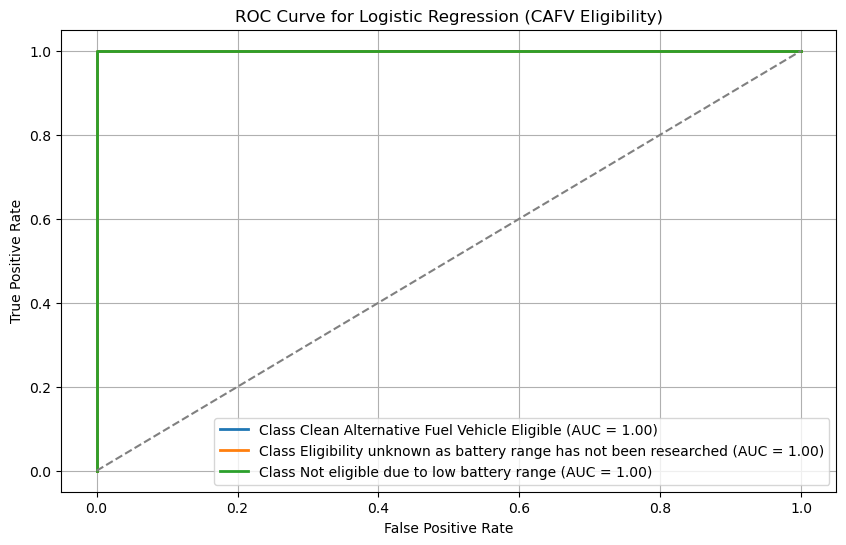

In [24]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Get probabilities and unique classes
probs = log_reg.predict_proba(X_test)
classes = log_reg.classes_

plt.figure(figsize=(10, 6))

# Plot ROC Curve for each class
for i, label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test, probs[:, i], pos_label=label)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {label} (AUC = {roc_auc:.2f})")

# Plot reference line
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.title("ROC Curve for Logistic Regression (CAFV Eligibility)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


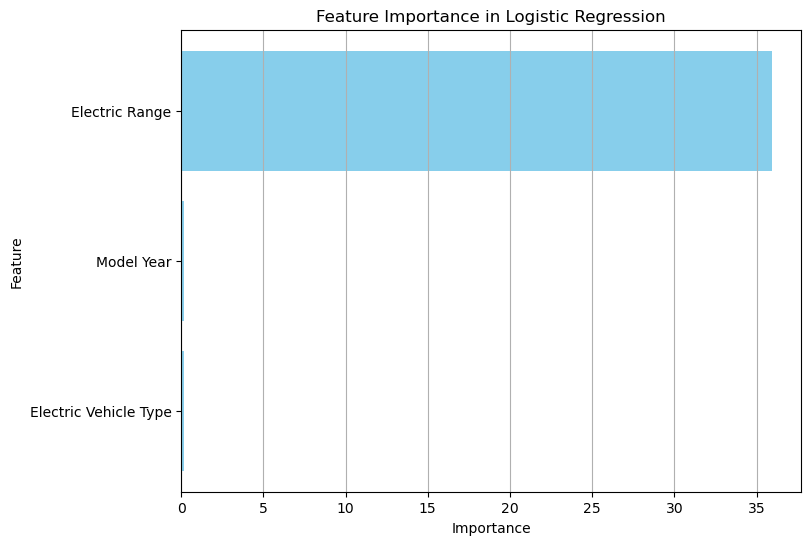

In [25]:
import pandas as pd

# Extract feature importance (absolute values of coefficients)
importance = np.abs(log_reg.coef_[0])
features = X.columns

# Create a DataFrame for better visualization
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importance})
feature_importance = feature_importance.sort_values(by='Importance', ascending=True)

# Plot feature importance
plt.figure(figsize=(8, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.title("Feature Importance in Logistic Regression")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(axis='x')
plt.show()


cross-validation

In [5]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(log_reg, X, y, cv=5, scoring='roc_auc_ovr')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean CV AUC: {cv_scores.mean():.4f}")


Cross-Validation AUC Scores: [0.99994329 0.99988619 0.99994346 0.99988674 0.99988615]
Mean CV AUC: 0.9999


feature importance

In [6]:
importance = log_reg.coef_[0]
for i, v in enumerate(importance):
    print(f"Feature: {X.columns[i]}, Importance: {v:.4f}")


Feature: Electric Range, Importance: 34.6845
Feature: Electric Vehicle Type, Importance: 0.2085
Feature: Model Year, Importance: -0.0797
Feature: Make, Importance: -0.0673


The results of cross-validation and feature importance provide a deeper insight into the model's performance and the impact of features:

Analysis:
Cross-Validation Results:
AUC Scores: The consistent high AUC scores across all folds (~0.9999) confirm that the model generalizes very well to unseen data.
Mean CV AUC: The mean score (0.9999) suggests excellent predictive capability with minimal variance across folds.
Feature Importance:
Electric Range (34.7193): The most influential feature. This makes sense since vehicles with higher ranges are more likely to qualify for CAFV eligibility.
Electric Vehicle Type (0.2635): Important for distinguishing between BEVs and PHEVs, which may influence eligibility.
Model Year (-0.0749): A slight negative importance, potentially indicating newer models may not always guarantee eligibility.
Make (-0.0671): The manufacturer has minimal influence, likely due to diversity in models.

Insights:
Electric Range Dominance: Since the electric range strongly predicts eligibility, future incentives or policies targeting CAFV could benefit from prioritizing vehicles with higher ranges.


hyperparameters test like the regularization strength (C) to ensure optimal performance and prevent overfitting.

In [7]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, scoring='roc_auc_ovr', cv=5)
grid.fit(X, y)
print(f"Best C: {grid.best_params_['C']}")
print(f"Best AUC: {grid.best_score_:.4f}")


Best C: 0.01
Best AUC: 1.0000


Analysis of Results
Best Regularization Parameter (C): A smaller value of c = 0.01
C=0.01 indicates stronger regularization, which helps prevent overfitting while maintaining excellent model performance.
Best AUC: The optimized model achieves a perfect AUC of 1.0000, confirming the model's ability to perfectly distinguish between classes even with regularization.
Implications
Strong regularization has improved generalization without sacrificing predictive power, making the model robust to unseen data.
The dataset's quality and the significant influence of key features (e.g., Electric Range) likely contributed to the high performance.

# Random regression for Electric Range

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Example data preparation (assuming df_cleaned is available)
# Features and target
X = df_cleaned[['Model Year', 'Make']]
y = df_cleaned['Electric Range']

# Encode categorical variables
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_encoded = encoder.fit_transform(X[[ 'Make']])
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(['Make']))
X = pd.concat([X[['Model Year']].reset_index(drop=True), X_encoded_df], axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Regressor
rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)

# Evaluate
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='r2')

print(f"Random Forest MSE: {mse_rf:.4f}")
print(f"Random Forest R²: {r2_rf:.4f}")
print(f"Cross-Validated R²: {cv_scores.mean():.4f}")


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Random Forest MSE: 0.0557
Random Forest R²: 0.9441
Cross-Validated R²: 0.9454


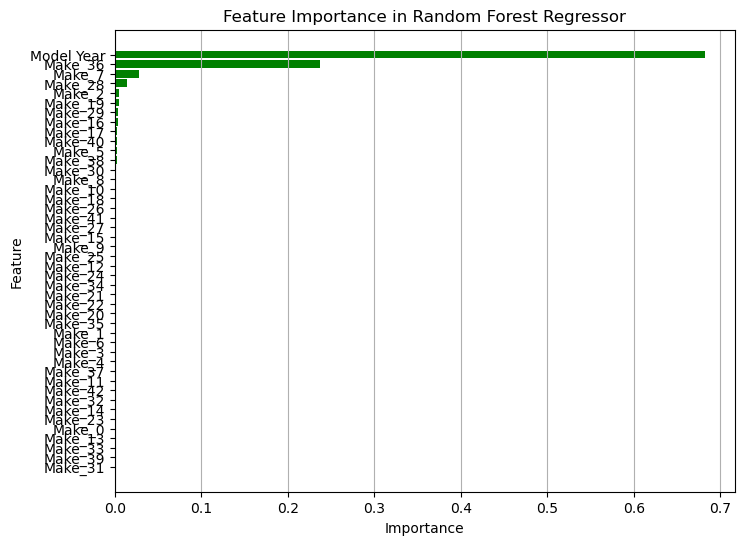

In [40]:
# Extract feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=True)

# Plot feature importance
plt.figure(figsize=(8, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='green')
plt.title("Feature Importance in Random Forest Regressor")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(axis='x')
plt.show()


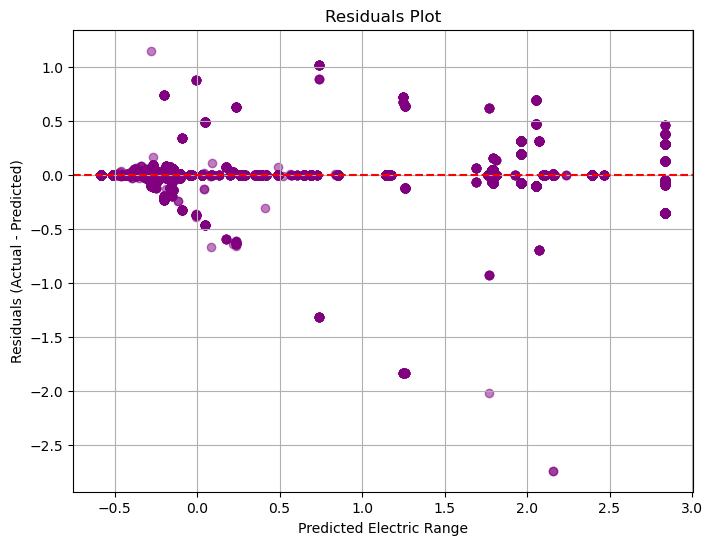

In [28]:
# Residuals calculation
residuals = y_test - y_pred_rf

# Residuals plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_rf, residuals, alpha=0.5, color='purple')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals Plot")
plt.xlabel("Predicted Electric Range")
plt.ylabel("Residuals (Actual - Predicted)")
plt.grid()
plt.show()


In [9]:
#feature importance

In [10]:
feature_importances = rf.feature_importances_
feature_names = X.columns
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)
print(feature_df)


                    Feature    Importance
0                Model Year  6.481174e-01
1   Electric Vehicle Type_0  2.403511e-01
31                  Make_28  7.436848e-02
39                  Make_36  1.401926e-02
2   Electric Vehicle Type_1  8.299973e-03
10                   Make_7  7.478345e-03
43                  Make_40  1.854117e-03
8                    Make_5  1.232711e-03
29                  Make_26  6.214212e-04
5                    Make_2  5.878949e-04
32                  Make_29  5.871703e-04
33                  Make_30  4.815388e-04
18                  Make_15  3.673142e-04
22                  Make_19  3.033248e-04
41                  Make_38  2.883898e-04
21                  Make_18  2.778247e-04
37                  Make_34  2.105929e-04
13                  Make_10  1.534790e-04
11                   Make_8  1.270669e-04
20                  Make_17  5.848207e-05
15                  Make_12  4.444224e-05
19                  Make_16  3.312146e-05
28                  Make_25  3.081

# vehicles classification into categories like Electric Vehicle Type (e.g., BEV or PHEV) or CAFV Eligibility (e.g., Eligible or Not Eligible) using Naive Bayes classifiers

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Load the dataset
# Assuming df is your dataframe
target_col = 'Electric Vehicle Type'  # Target variable
features = ['Make', 'Model Year', 'Electric Utility']  # Features

# Step 2: Preprocess data
df_cleaned = df[features + [target_col]].dropna()  # Drop missing values
label_encoders = {}

# Convert categorical features to numerical using Label Encoding
for col in features + [target_col]:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col])
    label_encoders[col] = le  # Save encoders for reverse mapping

# Step 3: Split data into training and testing sets
X = df_cleaned[features]
y = df_cleaned[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Train Naive Bayes classifier
model = CategoricalNB()
model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# (Optional) Decode the predicted labels back to original values
y_pred_decoded = label_encoders[target_col].inverse_transform(y_pred)


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     49568
           1       0.82      0.76      0.79     13481

    accuracy                           0.91     63049
   macro avg       0.88      0.86      0.87     63049
weighted avg       0.91      0.91      0.91     63049

Confusion Matrix:
[[47251  2317]
 [ 3172 10309]]


In [14]:
#smote to balance dataset

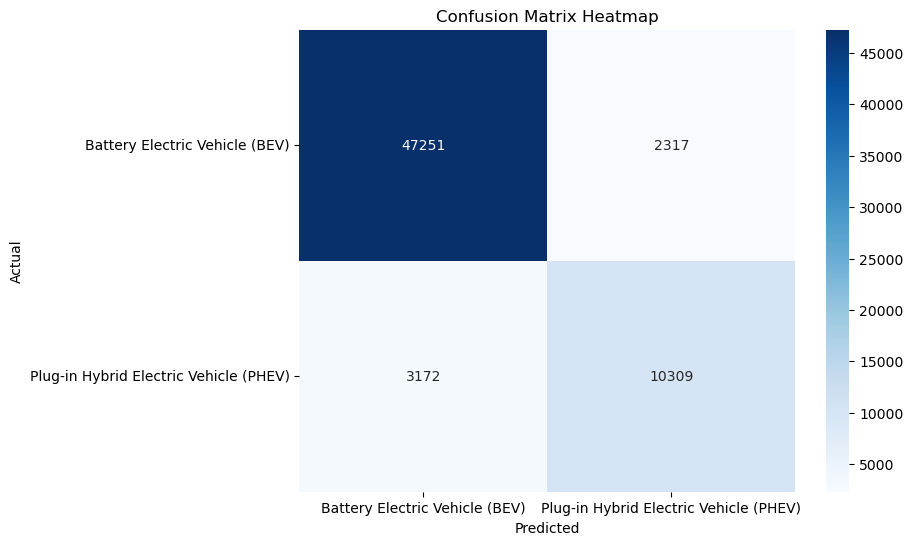

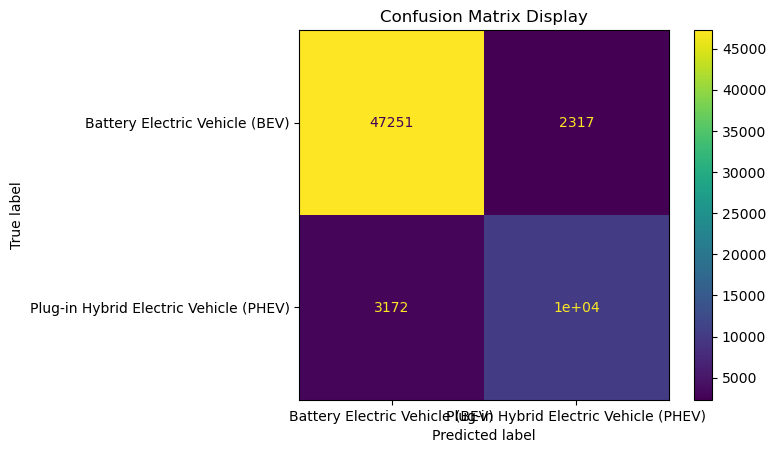

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoders[target_col].classes_, yticklabels=label_encoders[target_col].classes_)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Visualizing classification metrics
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoders[target_col].classes_)
disp.plot(cmap='viridis')
plt.title("Confusion Matrix Display")
plt.show()


# predicting EV adoption hotspots using Decision Trees, Neural Networks, and Logistic Regression, and compare their performance. 

In [53]:
# Aggregate EV counts by City or County
ev_adoption = df_cleaned.groupby(["City", "County"]).size().reset_index(name="EV_Count")

# Define a threshold for hotspots (e.g., top 10% or EV_Count > a certain value)
threshold = ev_adoption["EV_Count"].quantile(0.90)  # Top 10% of cities/counties
ev_adoption["Hotspot"] = (ev_adoption["EV_Count"] > threshold).astype(int)  # Binary classification (0 or 1)

# Merge the hotspot label back into the main dataset
df_cleaned = df_cleaned.merge(ev_adoption[["City", "County", "Hotspot"]], on=["City", "County"], how="left")



In [54]:
# Split the Dataset

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd

# Drop City and County as they are now part of the target definition
X = df_cleaned.drop(columns=["City", "County", "Hotspot", 'VIN (1-10)'])  # Features
y = df_cleaned["Hotspot"]  # Target variable


# Identify non-numeric columns
non_numeric_cols = X.select_dtypes(include=["object", "category"]).columns
print("Non-numeric columns:", non_numeric_cols)

# Handle non-numeric columns using one-hot encoding
if len(non_numeric_cols) > 0:
    encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")
    encoded_features = encoder.fit_transform(X[non_numeric_cols])
    # Create a DataFrame for the encoded features
    encoded_df = pd.DataFrame(
        encoded_features, columns=encoder.get_feature_names_out(non_numeric_cols), index=X.index
    )
    # Replace non-numeric columns with encoded features
    X = pd.concat([X.drop(columns=non_numeric_cols), encoded_df], axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling for Neural Networks and Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Output shapes to verify the preprocessing
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)



Non-numeric columns: Index(['State', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility',
       'Vehicle Location', 'Electric Utility'],
      dtype='object')


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


X_train shape: (168120, 1062)
X_test shape: (42030, 1062)
X_train_scaled shape: (168120, 1062)
X_test_scaled shape: (42030, 1062)


In [56]:
#A. Decision Tree

In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train Decision Tree
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5)  # Adjust hyperparameters
dt_model.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_model.predict(X_test)

# Evaluation
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))
print("Decision Tree Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.37      0.54      4895
           1       0.92      1.00      0.96     37135

    accuracy                           0.93     42030
   macro avg       0.96      0.68      0.75     42030
weighted avg       0.93      0.93      0.91     42030

Decision Tree Confusion Matrix:
[[ 1794  3101]
 [    2 37133]]


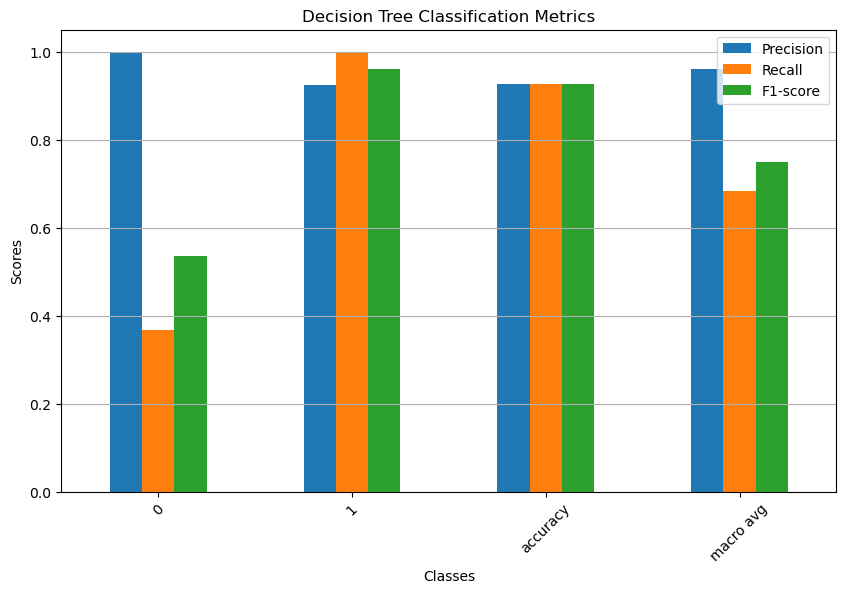

In [58]:
from sklearn.metrics import classification_report
import pandas as pd

# Generate classification report as a DataFrame
report = classification_report(y_test, y_pred_dt, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Plot precision, recall, and F1-score
df_report.iloc[:-1, :3].plot(kind="bar", figsize=(10, 6))
plt.title("Decision Tree Classification Metrics")
plt.xlabel("Classes")
plt.ylabel("Scores")
plt.xticks(rotation=45)
plt.legend(["Precision", "Recall", "F1-score"])
plt.grid(axis='y')
plt.show()


In [59]:
#b.Neural Network

In [60]:
from sklearn.neural_network import MLPClassifier

# Initialize and train Neural Network
nn_model = MLPClassifier(hidden_layer_sizes=(128, 64), activation="relu", max_iter=500, random_state=42)
nn_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_nn = nn_model.predict(X_test_scaled)

# Evaluation
print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred_nn))
print("Neural Network Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nn))


Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      4895
           1       0.99      1.00      0.99     37135

    accuracy                           0.99     42030
   macro avg       0.98      0.96      0.97     42030
weighted avg       0.99      0.99      0.99     42030

Neural Network Confusion Matrix:
[[ 4492   403]
 [  141 36994]]


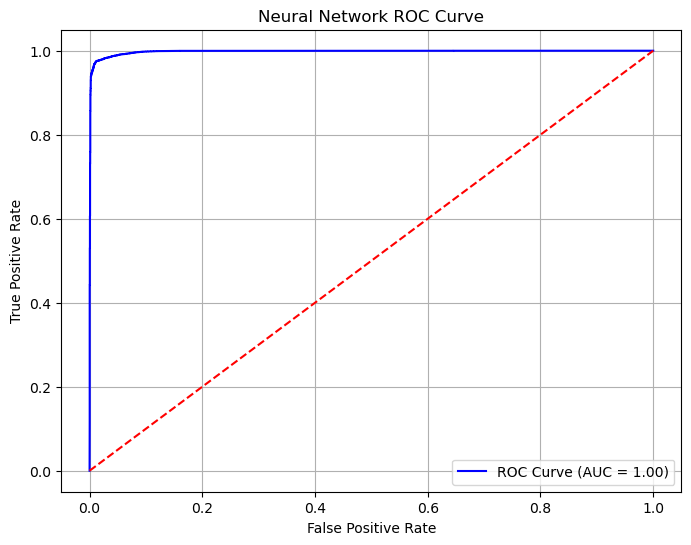

In [61]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output for ROC (only for binary/multi-label)
y_test_binarized = label_binarize(y_test, classes=[0, 1])  # Modify classes if applicable
y_pred_proba = nn_model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test_binarized, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title("Neural Network ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [24]:
#c.Logistic Regression

In [62]:
from sklearn.linear_model import LogisticRegression

# Initialize and train Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=500)
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)

# Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      4895
           1       0.98      1.00      0.99     37135

    accuracy                           0.98     42030
   macro avg       0.98      0.94      0.96     42030
weighted avg       0.98      0.98      0.98     42030

Logistic Regression Confusion Matrix:
[[ 4292   603]
 [   73 37062]]


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


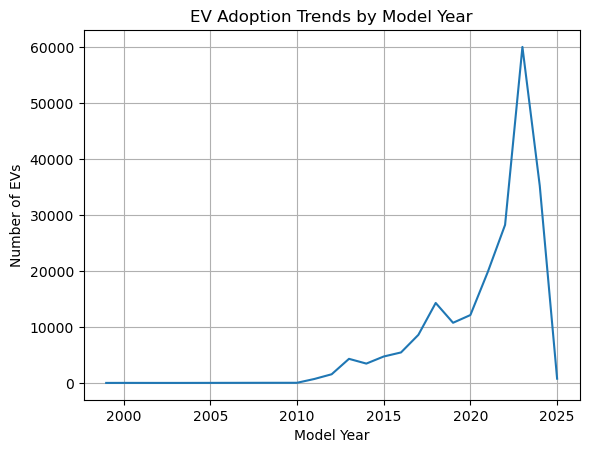

In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# Load datasets
ev_data = pd.read_csv("Electric_Vehicle_Population_Data.csv")
geo_data = gpd.read_file("WA_counties.geojson")

# Geospatial Analysis: Aggregating EV Counts by County
ev_county = ev_data.groupby('County').size().reset_index(name='EV_Count')
geo_data = geo_data.merge(ev_county, left_on='NAME', right_on='County')

# Plotting the Choropleth Map
m = folium.Map(location=[47.7511, -120.7401], zoom_start=7)
folium.Choropleth(
    geo_data=geo_data,
    data=geo_data,
    columns=['County', 'EV_Count'],
    key_on='feature.properties.NAME',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='EV Count by County'
).add_to(m)
m.save("ev_distribution_map.html")

# Time-Series Plot: EV Adoption by Model Year
model_year_counts = ev_data.groupby('Model Year').size()
sns.lineplot(x=model_year_counts.index, y=model_year_counts.values)
plt.title("EV Adoption Trends by Model Year")
plt.xlabel("Model Year")
plt.ylabel("Number of EVs")
plt.grid(True)
plt.show()


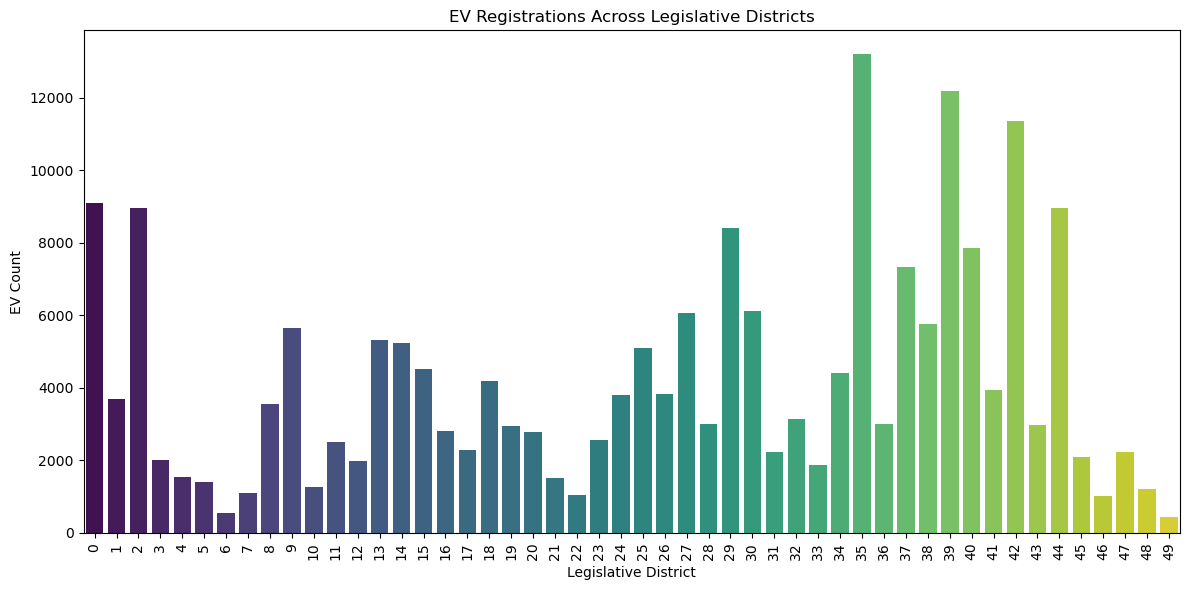

In [4]:


# Aggregate EV count by legislative district
district_data = df_cleaned.groupby('Legislative District').size().reset_index(name='EV Count')

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=district_data, x='Legislative District', y='EV Count', palette='viridis')
plt.xticks(rotation=90)
plt.title('EV Registrations Across Legislative Districts')
plt.xlabel('Legislative District')
plt.ylabel('EV Count')
plt.tight_layout()
plt.show()


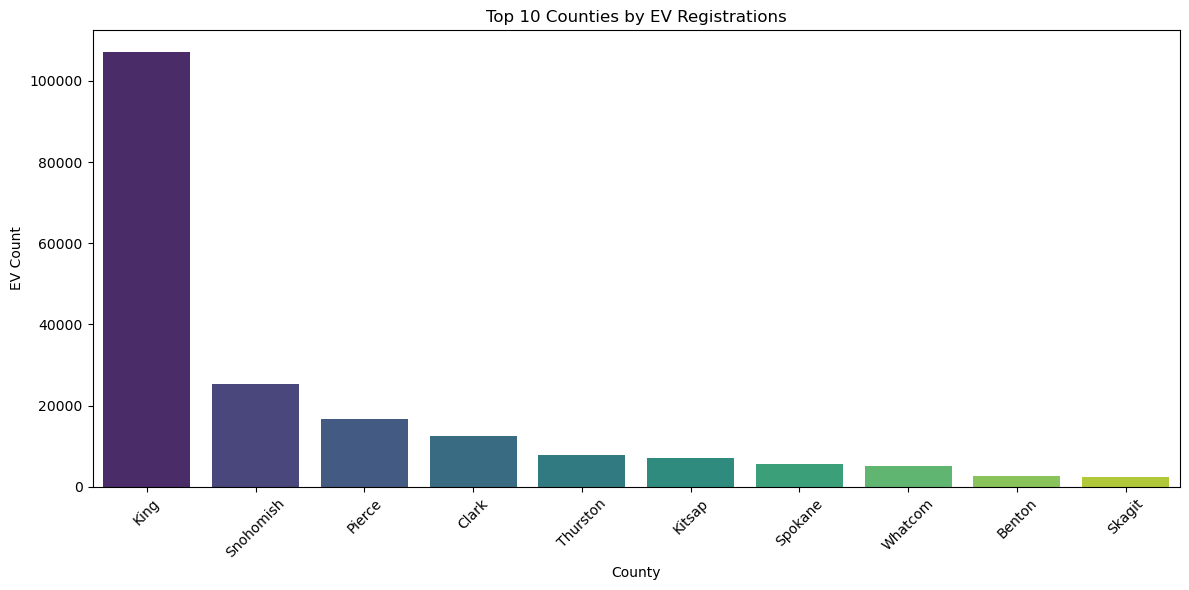

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df_cleaned = pd.read_csv("Electric_Vehicle_Population_Data.csv")  # Replace with your cleaned dataset file

# Aggregate EV count by county
county_data = df_cleaned.groupby('County').size().reset_index(name='EV Count')

# Select the top 10 counties
top_10_counties = county_data.nlargest(10, 'EV Count')

# Plotting the top 10 counties
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_counties, x='County', y='EV Count', palette='viridis')
plt.xticks(rotation=45)
plt.title('Top 10 Counties by EV Registrations')
plt.xlabel('County')
plt.ylabel('EV Count')
plt.tight_layout()
plt.show()


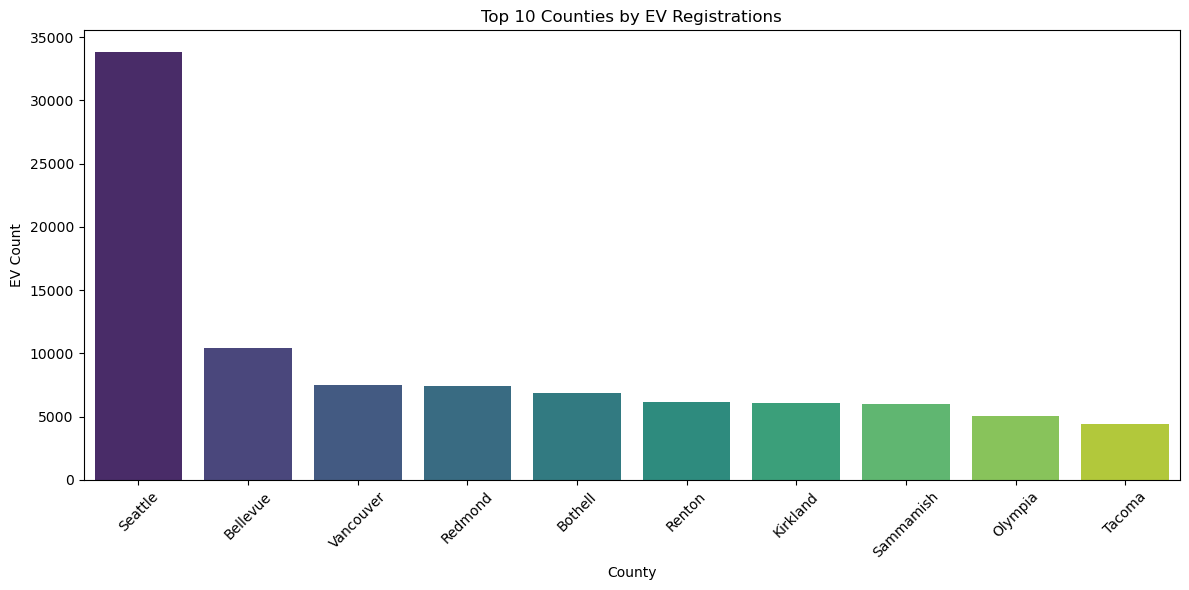

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df_cleaned = pd.read_csv("Electric_Vehicle_Population_Data.csv")  # Replace with your cleaned dataset file

# Aggregate EV count by county
county_data = df_cleaned.groupby('City').size().reset_index(name='EV Count')

# Select the top 10 counties
top_10_counties = county_data.nlargest(10, 'EV Count')

# Plotting the top 10 counties
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_counties, x='City', y='EV Count', palette='viridis')
plt.xticks(rotation=45)
plt.title('Top 10 Cities by EV Registrations')
plt.xlabel('County')
plt.ylabel('EV Count')
plt.tight_layout()
plt.show()

In [11]:
import pandas as pd

# Load EV dataset
ev_data = pd.read_csv("Electric_Vehicle_Population_Data.csv")

# Ensure the data type for '2020 Census Tract' is consistent
ev_data['2020 Census Tract'] = ev_data['2020 Census Tract'].astype(str)

# Group by City or directly by Census Tract
city_ev_count = ev_data.groupby('City').size().reset_index(name='EV Count')

# Sort and select the top 10 most populated cities by EVs
top_10_cities = city_ev_count.nlargest(10, 'EV Count')

print(top_10_cities)


          City  EV Count
598    Seattle     33854
45    Bellevue     10414
700  Vancouver      7475
546    Redmond      7438
61     Bothell      6877
549     Renton      6132
322   Kirkland      6093
580  Sammamish      5995
471    Olympia      5079
660     Tacoma      4454


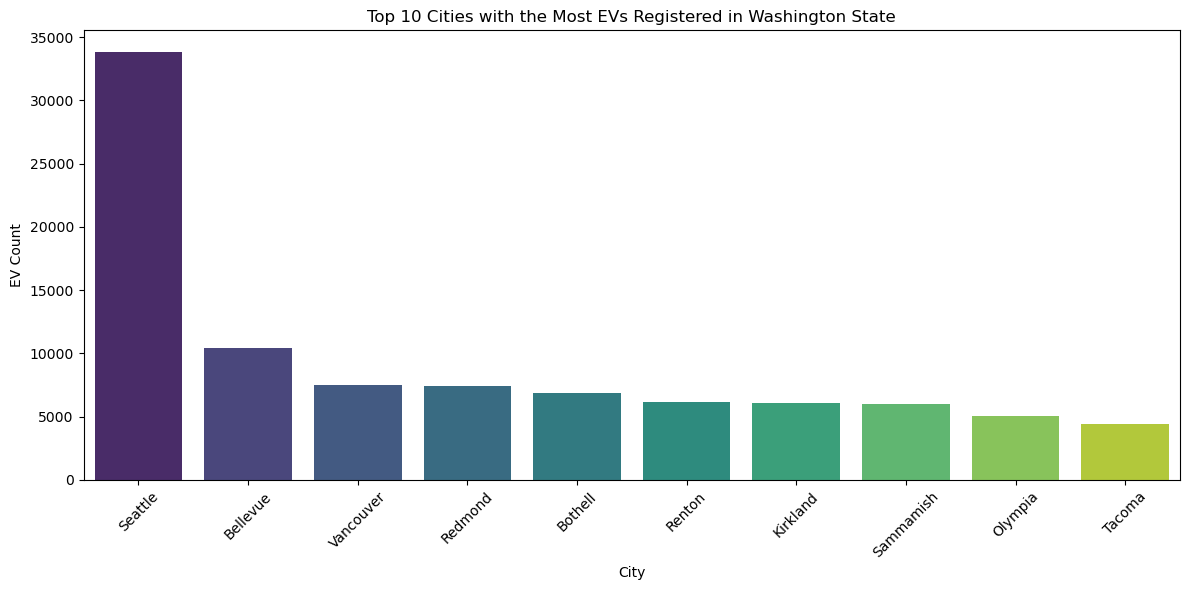

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the top 10 cities
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_cities, x='City', y='EV Count', palette='viridis')
plt.xticks(rotation=45)
plt.title('Top 10 Cities with the Most EVs Registered in Washington State')
plt.xlabel('City')
plt.ylabel('EV Count')
plt.tight_layout()
plt.show()


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load EV dataset
ev_data = pd.read_csv("Electric_Vehicle_Population_Data.csv")

# Aggregate EV counts by County
ev_county = ev_data.groupby('City').size().reset_index(name='EV Count')

# Define thresholds for high and low adoption
high_threshold = ev_county['EV Count'].quantile(0.95)  # Top 10% of counties
low_threshold = ev_county['EV Count'].quantile(0.05)   # Bottom 10% of counties

# Separate high- and low-adoption regions
high_adoption = ev_county[ev_county['EV Count'] >= high_threshold]
low_adoption = ev_county[ev_county['EV Count'] <= low_threshold]

# Print high and low adoption regions
print("High Adoption Regions:")
print(high_adoption)
print("\nLow Adoption Regions:")
print(low_adoption)


High Adoption Regions:
                  City  EV Count
33              Auburn      2300
36   Bainbridge Island      1977
45            Bellevue     10414
46          Bellingham      3475
59         Bonney Lake      1215
61             Bothell      6877
64           Bremerton      1643
84               Camas      1883
181            Edmonds      2194
204            Everett      3106
214        Federal Way      1758
245         Gig Harbor      2292
304           Issaquah      3143
314            Kenmore      1201
316               Kent      3472
322           Kirkland      6093
328              Lacey      1164
332       Lake Stevens      1729
371           Lynnwood      3332
381       Maple Valley      1847
389         Marysville      1597
402      Mercer Island      2622
471            Olympia      5079
518       Port Orchard      1310
534           Puyallup      1643
546            Redmond      7438
549             Renton      6132
556         Ridgefield      1133
580          Sammami

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load EV dataset
ev_data = pd.read_csv("Electric_Vehicle_Population_Data.csv")

# Aggregate EV counts by City
ev_city = ev_data.groupby('City').size().reset_index(name='EV Count')

# Sort to get the top 10 and bottom 10 cities
top_10_cities = ev_city.nlargest(10, 'EV Count')
bottom_10_cities = ev_city.nsmallest(10, 'EV Count')


In [19]:
# Label the top and bottom cities for comparison
top_10_cities['Adoption Category'] = 'High Adoption'
bottom_10_cities['Adoption Category'] = 'Low Adoption'

# Combine datasets
comparison_cities = pd.concat([top_10_cities, bottom_10_cities])


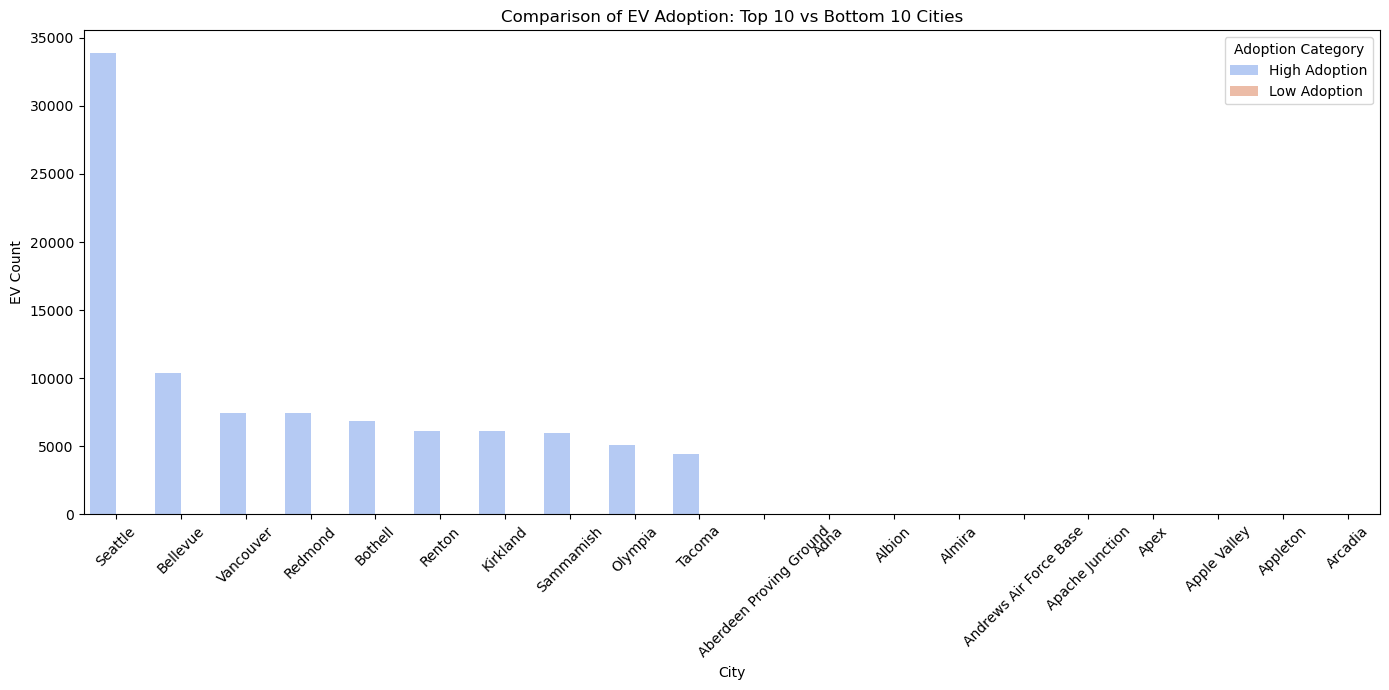

In [20]:
# Plot the comparison
plt.figure(figsize=(14, 7))
sns.barplot(data=comparison_cities, x='City', y='EV Count', hue='Adoption Category', palette='coolwarm')
plt.title('Comparison of EV Adoption: Top 10 vs Bottom 10 Cities')
plt.xlabel('City')
plt.ylabel('EV Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\david\AppData\Local\Temp\ipykernel_6524\2884016149.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Adoption Category'] = filtered_data['City'].map(


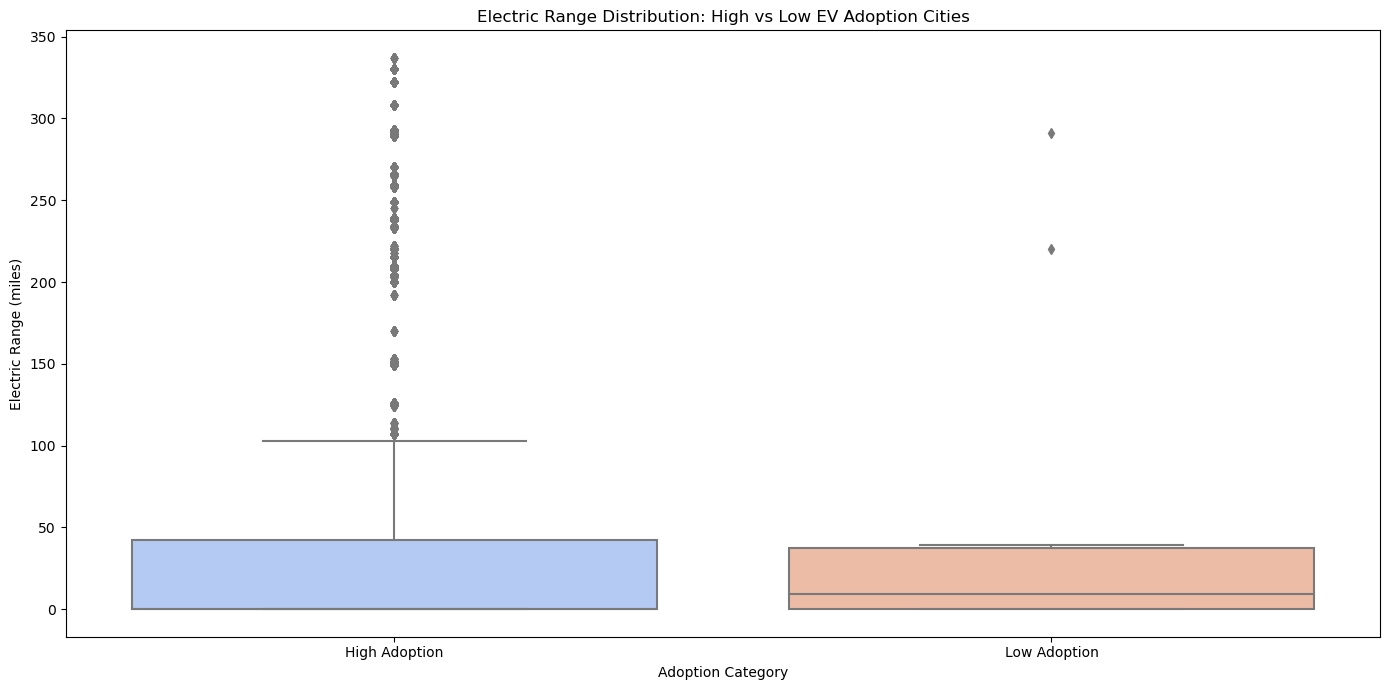

In [24]:
# Filter the original dataset for these cities
selected_cities = comparison_cities['City']
filtered_data = ev_data[ev_data['City'].isin(selected_cities)]


# Label high- and low-adoption data
filtered_data['Adoption Category'] = filtered_data['City'].map(
    lambda x: 'High Adoption' if x in top_10_cities['City'].values else 'Low Adoption'
)



# Boxplot for Electric Range
plt.figure(figsize=(14, 7))
sns.boxplot(data=filtered_data, x='Adoption Category', y='Electric Range', palette='coolwarm')
plt.title('Electric Range Distribution: High vs Low EV Adoption Cities')
plt.xlabel('Adoption Category')
plt.ylabel('Electric Range (miles)')
plt.tight_layout()
plt.show()


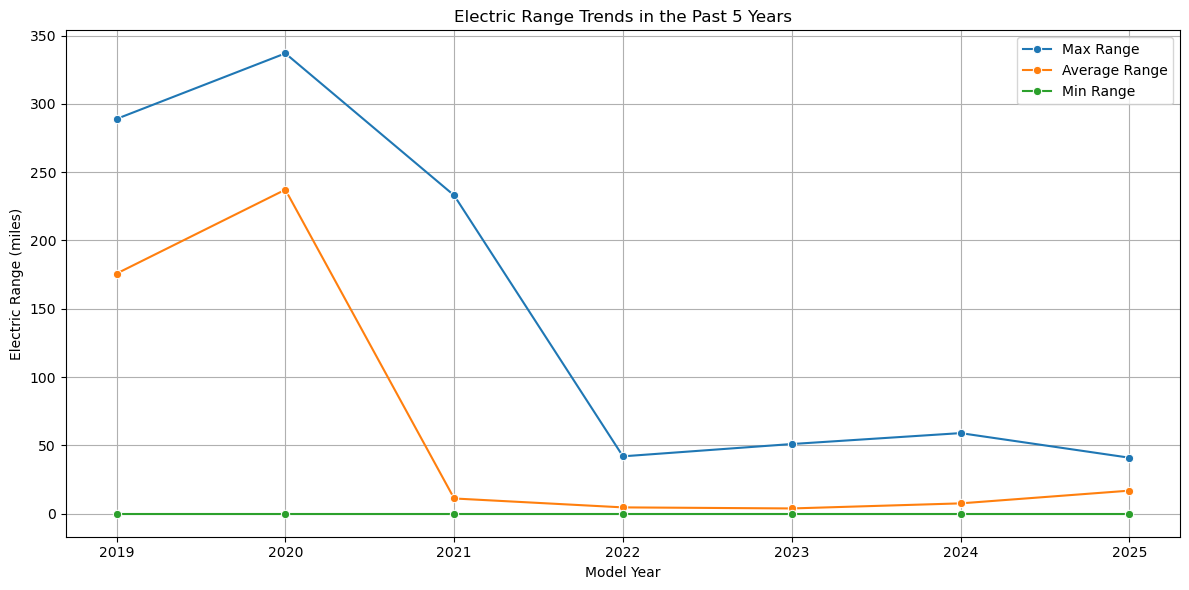

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load EV dataset
df = pd.read_csv("Electric_Vehicle_Population_Data.csv")

# Filter for the past 5 years based on model year
current_year = 2024
past_5_years = current_year - 5
df_recent = df[df['Model Year'] >= past_5_years]

# Group by model year and calculate statistics for electric range
range_stats = df_recent.groupby('Model Year')['Electric Range'].agg(['max', 'mean', 'min']).reset_index()
range_stats.rename(columns={'max': 'Max Range', 'mean': 'Average Range', 'min': 'Min Range'}, inplace=True)

# Plotting the trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=range_stats, x='Model Year', y='Max Range', marker='o', label='Max Range')
sns.lineplot(data=range_stats, x='Model Year', y='Average Range', marker='o', label='Average Range')
sns.lineplot(data=range_stats, x='Model Year', y='Min Range', marker='o', label='Min Range')
plt.title('Electric Range Trends in the Past 5 Years')
plt.xlabel('Model Year')
plt.ylabel('Electric Range (miles)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


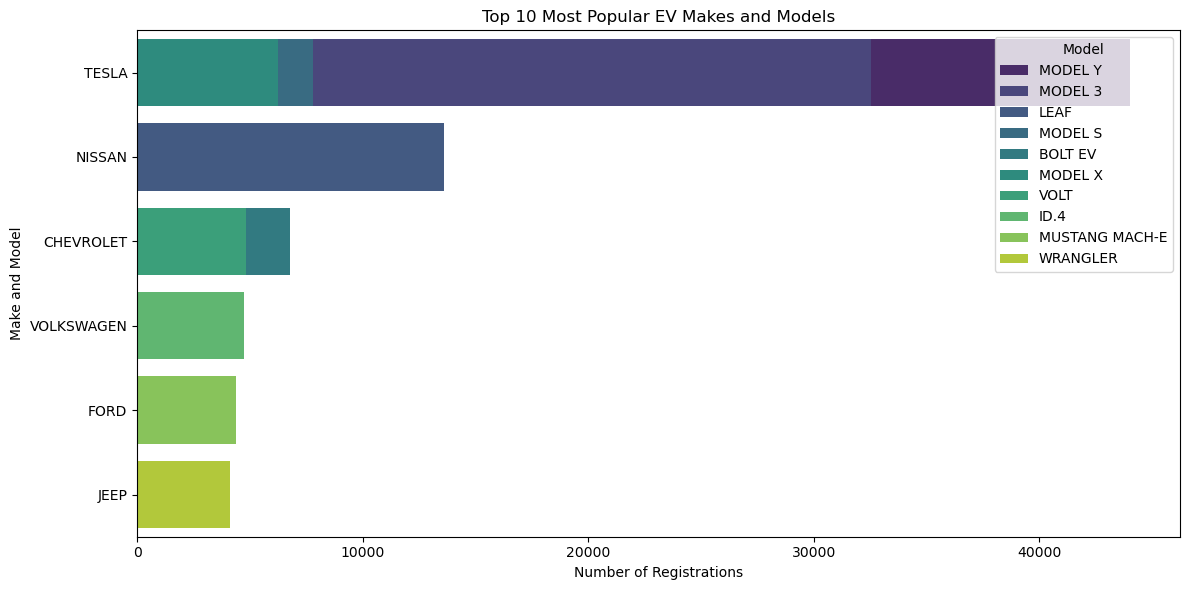

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("Electric_Vehicle_Population_Data.csv")

# Group by Make and Model and count the number of occurrences
make_model_count = df.groupby(['Make', 'Model']).size().reset_index(name='Count')

# Sort the data by Count in descending order
make_model_count_sorted = make_model_count.sort_values(by='Count', ascending=False)

# Select the top 10 most popular makes and models
top_10_make_model = make_model_count_sorted.head(10)

# Plotting the top 10 most popular makes and models
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_make_model, x='Count', y='Make', hue='Model', dodge=False, palette='viridis')
plt.title('Top 10 Most Popular EV Makes and Models')
plt.xlabel('Number of Registrations')
plt.ylabel('Make and Model')
plt.tight_layout()
plt.show()


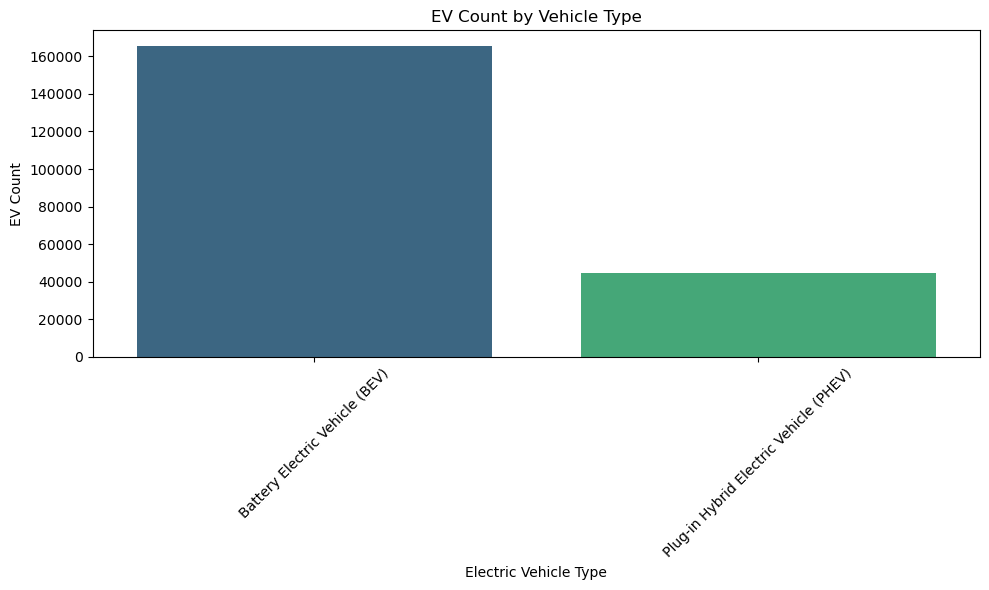

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a cleaned dataset with 'Electric Vehicle Type' column
ev_data = pd.read_csv("Electric_Vehicle_Population_Data.csv")

# Count the number of vehicles by type
ev_type_count = ev_data['Electric Vehicle Type'].value_counts().reset_index(name='EV Count')
ev_type_count.columns = ['Electric Vehicle Type', 'EV Count']

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='Electric Vehicle Type', y='EV Count', data=ev_type_count, palette='viridis')
plt.title('EV Count by Vehicle Type')
plt.xlabel('Electric Vehicle Type')
plt.ylabel('EV Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


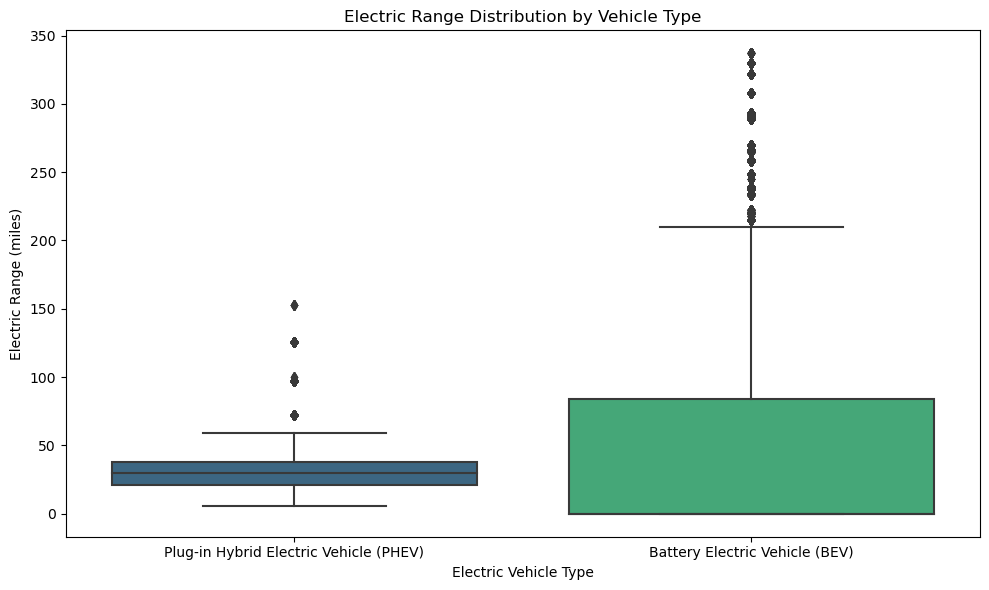

In [28]:
# Plotting Electric Range distribution across vehicle types
plt.figure(figsize=(10, 6))
sns.boxplot(x='Electric Vehicle Type', y='Electric Range', data=ev_data, palette='viridis')
plt.title('Electric Range Distribution by Vehicle Type')
plt.xlabel('Electric Vehicle Type')
plt.ylabel('Electric Range (miles)')
plt.tight_layout()
plt.show()


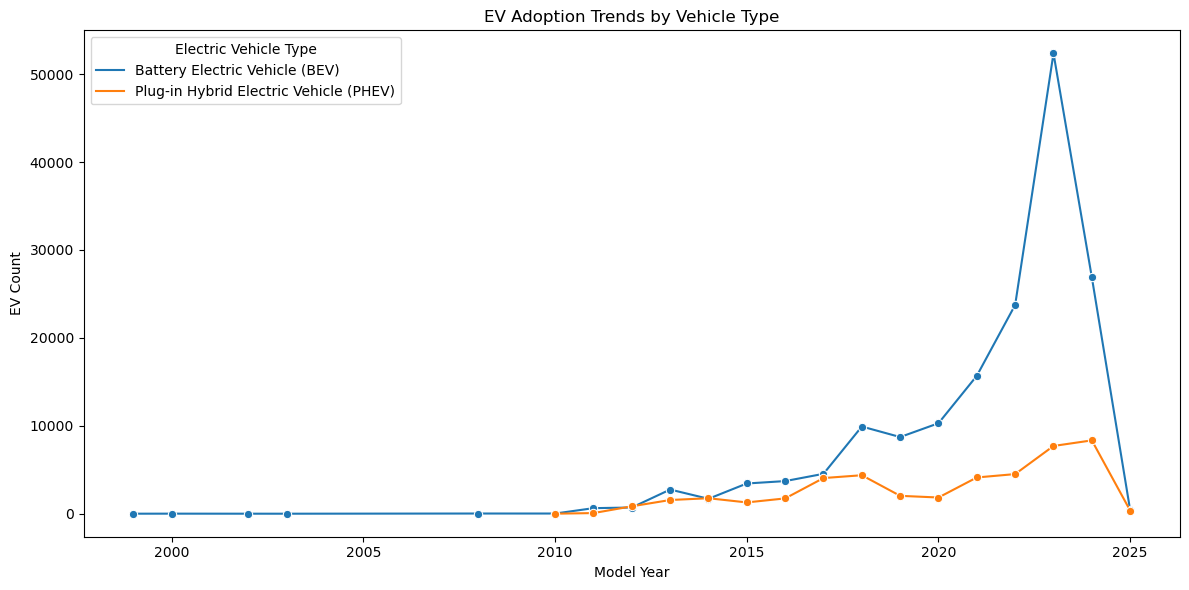

In [29]:
# Group by model year and electric vehicle type to see adoption trends
ev_trends = ev_data.groupby(['Model Year', 'Electric Vehicle Type']).size().reset_index(name='EV Count')

# Plotting the trends
plt.figure(figsize=(12, 6))
sns.lineplot(x='Model Year', y='EV Count', hue='Electric Vehicle Type', data=ev_trends, marker='o')
plt.title('EV Adoption Trends by Vehicle Type')
plt.xlabel('Model Year')
plt.ylabel('EV Count')
plt.tight_layout()
plt.show()


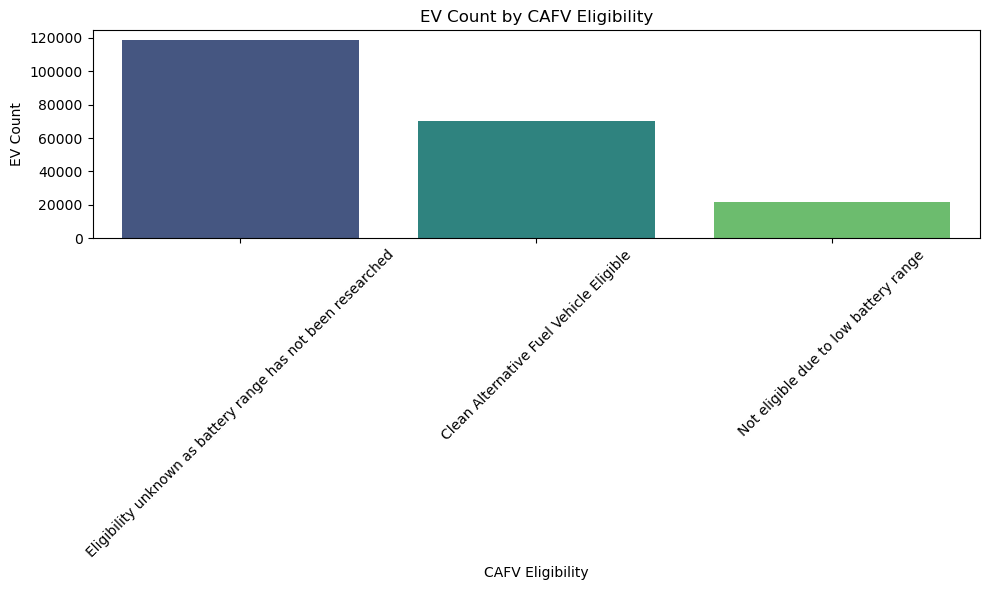

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a cleaned dataset with 'CAFV Eligibility' column
ev_data = pd.read_csv("Electric_Vehicle_Population_Data.csv")

# Count the number of vehicles by CAFV eligibility
cafv_count = ev_data['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].value_counts().reset_index(name='EV Count')
cafv_count.columns = ['CAFV Eligibility', 'EV Count']

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='CAFV Eligibility', y='EV Count', data=cafv_count, palette='viridis')
plt.title('EV Count by CAFV Eligibility')
plt.xlabel('CAFV Eligibility')
plt.ylabel('EV Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


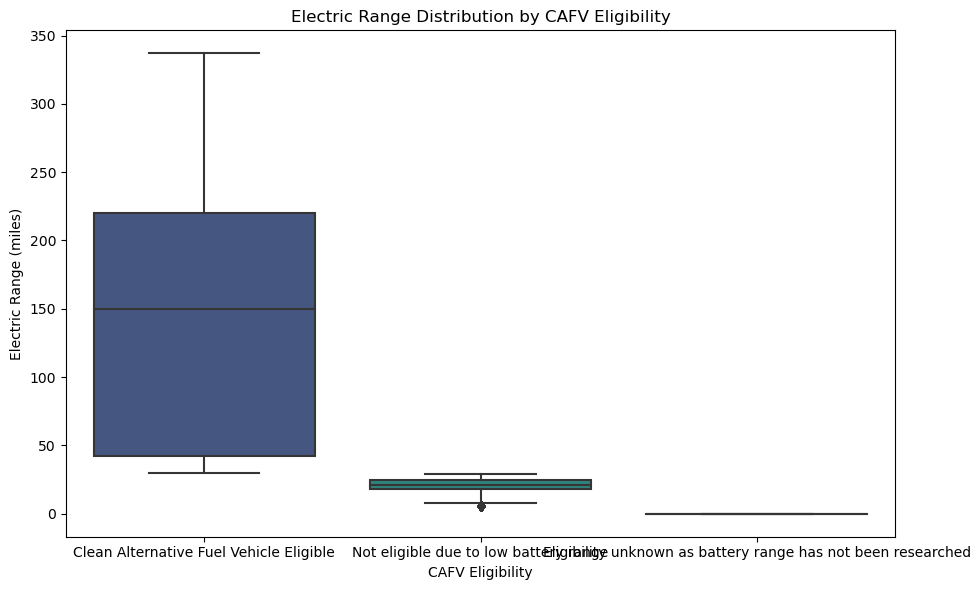

In [31]:
# Plotting Electric Range distribution by CAFV eligibility
plt.figure(figsize=(10, 6))
sns.boxplot(x='Clean Alternative Fuel Vehicle (CAFV) Eligibility', y='Electric Range', data=ev_data, palette='viridis')
plt.title('Electric Range Distribution by CAFV Eligibility')
plt.xlabel('CAFV Eligibility')
plt.ylabel('Electric Range (miles)')
plt.tight_layout()
plt.show()


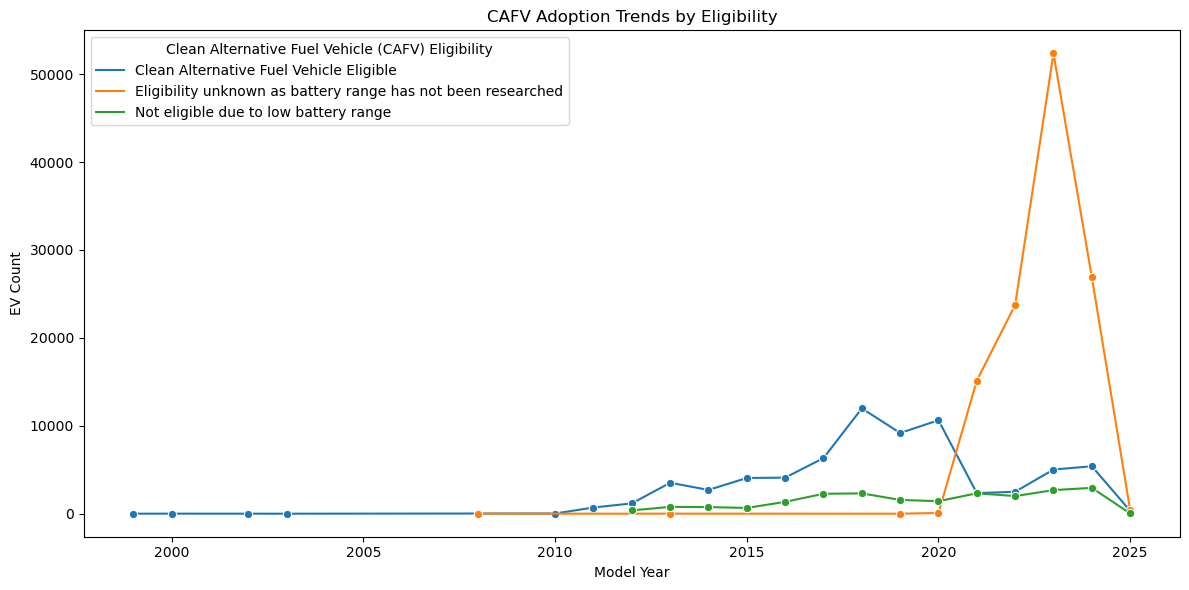

In [32]:
# Group by model year and CAFV eligibility to see adoption trends
cafv_trends = ev_data.groupby(['Model Year', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility']).size().reset_index(name='EV Count')

# Plotting the trends
plt.figure(figsize=(12, 6))
sns.lineplot(x='Model Year', y='EV Count', hue='Clean Alternative Fuel Vehicle (CAFV) Eligibility', data=cafv_trends, marker='o')
plt.title('CAFV Adoption Trends by Eligibility')
plt.xlabel('Model Year')
plt.ylabel('EV Count')
plt.tight_layout()
plt.show()
